In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pennylane as qml

from sklearn.model_selection import train_test_split

# Direct classes included for easyness
from tensorflow.keras.utils import plot_model
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Model

In [2]:
# load data
np_data = np.load("data/dataRS.npy")

noise_output = np_data[:,-1].reshape(len(np_data),1)
input = np_data[:,:-1]

# split data
test_split = 0.33
x_train, x_test, y_train, y_test = train_test_split(input, noise_output, test_size=test_split)

### Enter your tag as unique id for saving

In [3]:
tag = str("QAutoencoder-18032023")

In [4]:
from pennylane import numpy as np
n_qubits = x_train.shape[1]
compression = 3

dev = qml.device("default.qubit", wires=n_qubits)

Params in the quantum layer to train: 45
0: ──RX(0.07)──Rot(0.38,0.32,0.67)─╭●──────────────────╭●──────────────────╭●───────
1: ──RX(0.00)──Rot(0.30,0.90,0.89)─╰RX(0.82)─╭●────────╰RY(0.75)─╭●────────╰RZ(0.05)
2: ──RX(0.00)──Rot(0.85,0.55,0.39)───────────╰RX(0.12)─╭●────────╰RY(0.67)─╭●───────
3: ──RX(0.20)──Rot(0.43,0.36,0.98)─────────────────────╰RX(0.99)─╭●────────╰RY(1.00)
4: ──RX(0.00)──Rot(0.38,0.60,0.39)───────────────────────────────╰RX(0.66)──────────

───Rot(0.51,0.63,0.63)────────────────────────────────────────────────────────────────┤     
──╭●────────────────────Rot(0.95,0.02,0.20)───────────────────────────────────────────┤  <Z>
──╰RZ(0.21)────────────╭●────────────────────Rot(0.24,0.41,1.00)──────────────────────┤  <Z>
──╭●───────────────────╰RZ(0.32)────────────╭●────────────────────Rot(0.81,0.95,0.55)─┤  <Z>
──╰RY(0.38)─────────────────────────────────╰RZ(0.95)─────────────Rot(0.89,0.03,0.96)─┤     


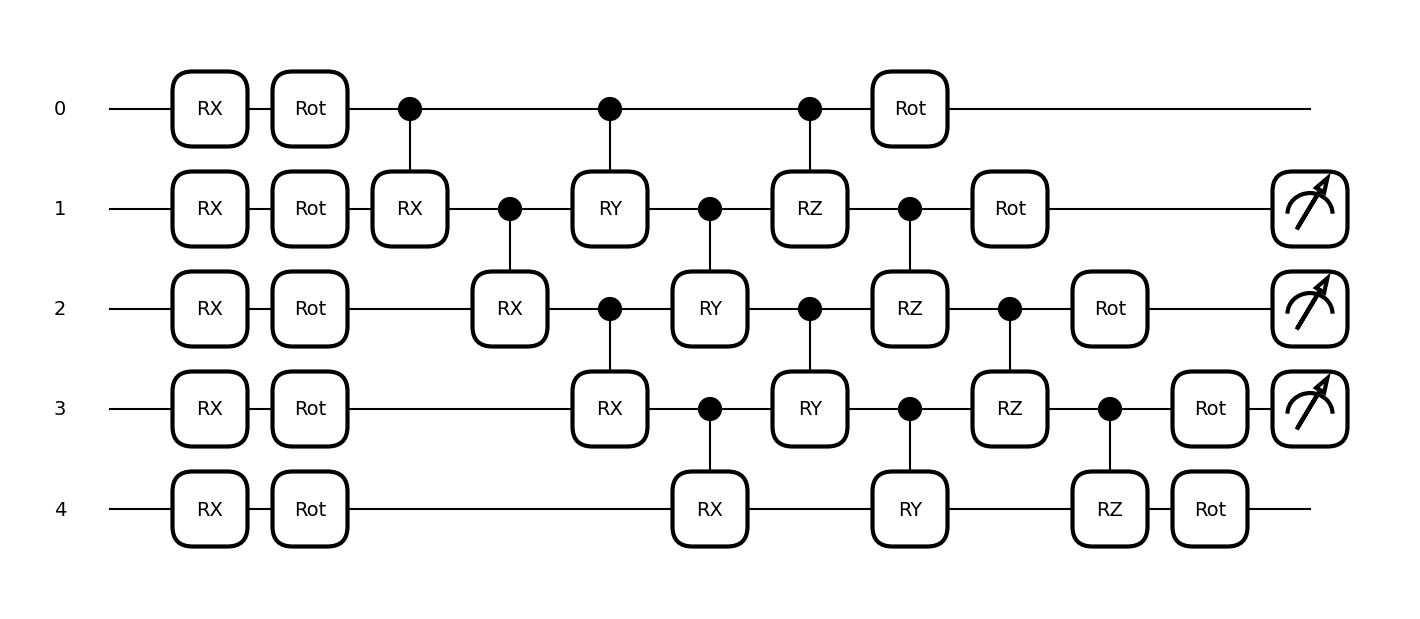

<Figure size 640x480 with 0 Axes>

In [5]:
# Encoder
ENC_weight_shapes = {"weight1": (n_qubits,3),
                 "weight2": (n_qubits-1),
                 "weight3": (n_qubits-1),
                 "weight4": (n_qubits-1),
                 "weight5": (n_qubits,3)}
nE_qcParams = n_qubits*3+2*3*n_qubits
print(f"Params in the quantum layer to train: {nE_qcParams}")



@qml.qnode(dev)
def encoder(inputs, weight1, weight2, weight3, weight4, weight5):
    qml.broadcast(qml.RX, wires=range(n_qubits), parameters=inputs, pattern="single")
    
    qml.broadcast(qml.Rot, wires=range(n_qubits), parameters=weight1, pattern="single")
    qml.broadcast(qml.CRX, wires=range(n_qubits), parameters=weight2, pattern="chain")
    qml.broadcast(qml.CRY, wires=range(n_qubits), parameters=weight3, pattern="chain")
    qml.broadcast(qml.CRZ, wires=range(n_qubits), parameters=weight4, pattern="chain")
    qml.broadcast(qml.Rot, wires=range(n_qubits), parameters=weight5, pattern="single")
    
    return [qml.expval(qml.PauliZ(wires=i+1)) for i in range(compression)]

qEncoder = qml.qnn.KerasLayer(encoder, ENC_weight_shapes, output_dim=n_qubits)

# Visualize the quantum circuit
print(qml.draw(encoder)(x_train[0,:],np.random.rand(n_qubits,3), np.random.rand(n_qubits-1), np.random.rand(n_qubits-1), np.random.rand(n_qubits-1), np.random.rand(n_qubits,3)))
fig, ax = qml.draw_mpl(encoder)(x_train[0,:],np.random.rand(n_qubits,3), np.random.rand(n_qubits-1), np.random.rand(n_qubits-1), np.random.rand(n_qubits-1), np.random.rand(n_qubits,3))
plt.show()
plt.savefig("archive/Encoder-"+tag+".png")

Params in the quantum layer to train: 45
0: ──Rot(0.16,0.37,0.45)──────────────────────╭●──────────────────╭●──────────────────╭●───────
1: ──RX(0.07)─────────────Rot(0.86,0.38,0.17)─╰RX(0.07)─╭●────────╰RY(0.43)─╭●────────╰RZ(0.65)
2: ──RX(0.00)─────────────Rot(0.54,0.11,0.03)───────────╰RX(0.50)─╭●────────╰RY(0.64)─╭●───────
3: ──RX(0.00)─────────────Rot(0.99,0.67,0.12)─────────────────────╰RX(0.82)─╭●────────╰RY(0.75)
4: ──Rot(0.07,0.46,0.81)────────────────────────────────────────────────────╰RX(0.50)──────────

───Rot(0.78,0.31,0.65)────────────────────────────────────────────────────────────────┤  <Z>
──╭●────────────────────Rot(0.98,0.61,0.51)───────────────────────────────────────────┤  <Z>
──╰RZ(0.68)────────────╭●────────────────────Rot(0.76,0.22,0.51)──────────────────────┤  <Z>
──╭●───────────────────╰RZ(0.51)────────────╭●────────────────────Rot(0.16,0.08,0.76)─┤  <Z>
──╰RY(0.01)─────────────────────────────────╰RZ(0.17)─────────────Rot(0.46,0.02,0.78)─┤  <Z>


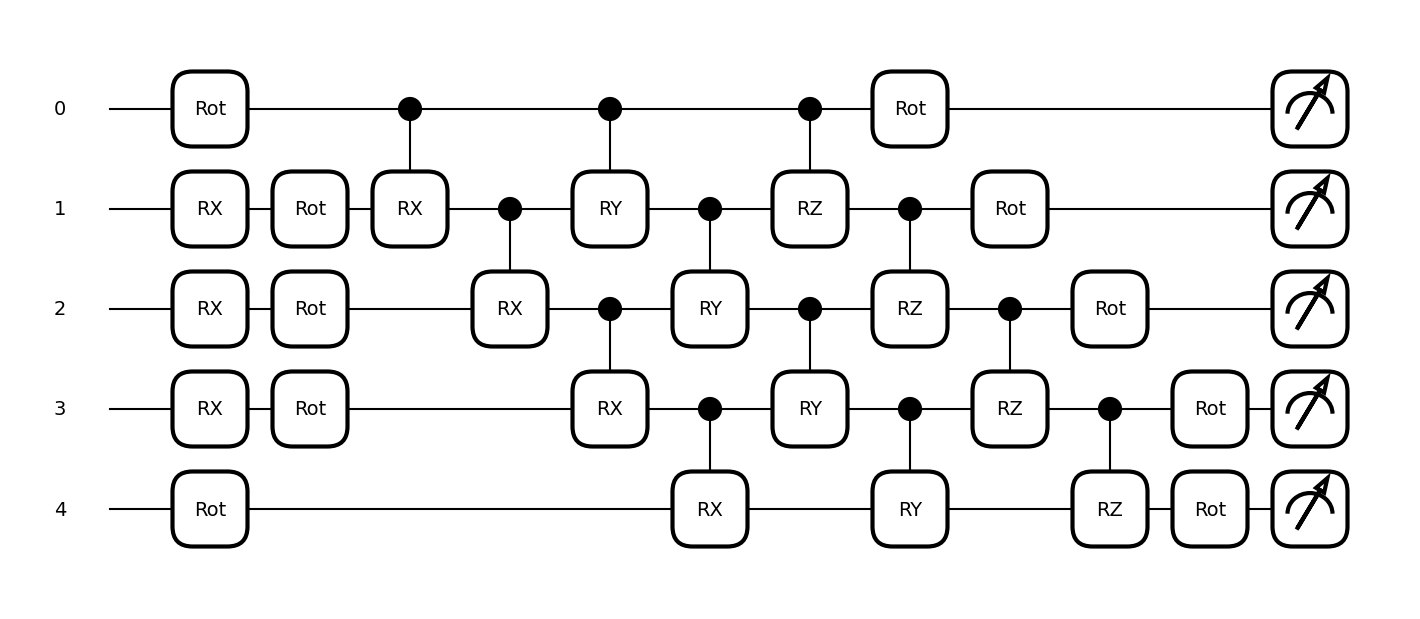

<Figure size 640x480 with 0 Axes>

In [6]:
# Decoder
DEC_weight_shapes = {"weight1": (n_qubits,3),
                 "weight2": (n_qubits-1),
                 "weight3": (n_qubits-1),
                 "weight4": (n_qubits-1),
                 "weight5": (n_qubits,3)}
nD_qcParams = n_qubits*3+2*3*n_qubits
print(f"Params in the quantum layer to train: {nD_qcParams}")



@qml.qnode(dev)
def decoder(inputs, weight1, weight2, weight3, weight4, weight5):
    qml.broadcast(qml.RX, wires=[1,2,3], parameters=inputs, pattern="single")
    
    qml.broadcast(qml.Rot, wires=range(n_qubits), parameters=weight1, pattern="single")
    qml.broadcast(qml.CRX, wires=range(n_qubits), parameters=weight2, pattern="chain")
    qml.broadcast(qml.CRY, wires=range(n_qubits), parameters=weight3, pattern="chain")
    qml.broadcast(qml.CRZ, wires=range(n_qubits), parameters=weight4, pattern="chain")
    qml.broadcast(qml.Rot, wires=range(n_qubits), parameters=weight5, pattern="single")
    
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qDecoder = qml.qnn.KerasLayer(decoder, DEC_weight_shapes, output_dim=n_qubits)

# Visualize the quantum circuit
print(qml.draw(decoder)(x_train[0,:3],np.random.rand(n_qubits,3), np.random.rand(n_qubits-1), np.random.rand(n_qubits-1), np.random.rand(n_qubits-1), np.random.rand(n_qubits,3)))
fig, ax = qml.draw_mpl(decoder)(x_train[0,:3],np.random.rand(n_qubits,3), np.random.rand(n_qubits-1), np.random.rand(n_qubits-1), np.random.rand(n_qubits-1), np.random.rand(n_qubits,3))
plt.show()
plt.savefig("archive/Decoder-"+tag+".png")

In [7]:
#Create a autoencode like in https://blog.keras.io/building-autoencoders-in-keras.html
clear_session()

inputLayer = Input(shape=(x_train.shape[1],))
encoded = qEncoder(inputLayer)
decoded = qDecoder(encoded)
autoencoder = Model(inputLayer, decoded)
print(f"Params in all quantum layers to train: {nD_qcParams+nE_qcParams}")
autoencoder.summary()
plot_model(autoencoder)

Params in all quantum layers to train: 90
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5)]               0         
                                                                 
 keras_layer (KerasLayer)    (None, 5)                 0 (unused)
                                                                 
 keras_layer_1 (KerasLayer)  (None, 5)                 0 (unused)
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [8]:
# Encoder
encoder = Model(inputLayer, encoded)
# Decoder
encoded_input = Input(shape=(compression,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))


In [9]:
#Training
def scheduler(epoch, lr):
    if epoch < 6:
        return lr
    else:
        return lr* tf.math.exp(-0.1)
LearningRateScheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="auto", min_delta=0.001, patience=3)

optRMS = tf.keras.optimizers.RMSprop(learning_rate=0.2,)

autoencoder.compile(optRMS, loss='mean_squared_error', metrics=['mean_absolute_error'])

autoencoder_history = autoencoder.fit(x_train, x_train, epochs=50, batch_size=25, validation_split=0.25, callbacks=[LearningRateScheduler, EarlyStopping])

Epoch 1/50
31/31 [==============================] - 267s 9s/step - loss: 0.0964 - mean_absolute_error: 0.2378 - val_loss: 0.0972 - val_mean_absolute_error: 0.2434 - lr: 0.2000
Epoch 2/50
31/31 [==============================] - 266s 9s/step - loss: 0.0550 - mean_absolute_error: 0.1833 - val_loss: 0.0790 - val_mean_absolute_error: 0.2302 - lr: 0.2000
Epoch 3/50
31/31 [==============================] - 263s 9s/step - loss: 0.0503 - mean_absolute_error: 0.1753 - val_loss: 0.0308 - val_mean_absolute_error: 0.1423 - lr: 0.2000
Epoch 4/50
31/31 [==============================] - 257s 8s/step - loss: 0.0483 - mean_absolute_error: 0.1700 - val_loss: 0.0400 - val_mean_absolute_error: 0.1482 - lr: 0.2000
Epoch 5/50
31/31 [==============================] - 256s 8s/step - loss: 0.0574 - mean_absolute_error: 0.1867 - val_loss: 0.0385 - val_mean_absolute_error: 0.1590 - lr: 0.2000
Epoch 6/50
31/31 [==============================] - 271s 9s/step - loss: 0.0479 - mean_absolute_error: 0.1675 - val_loss

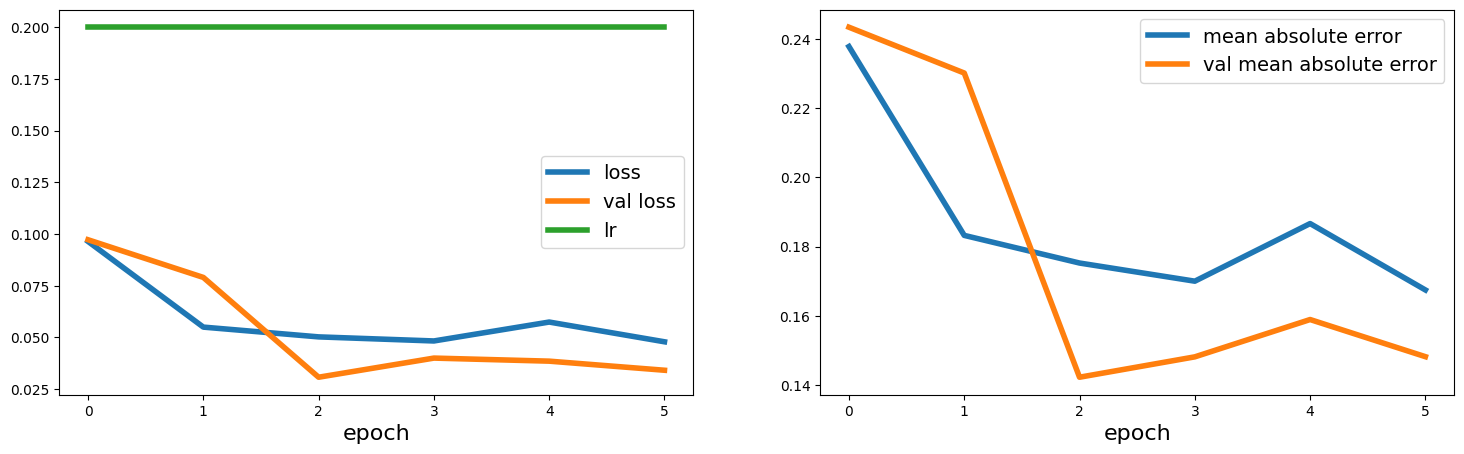

In [10]:
import numpy as np

def plot_metrics(history):
    n = len(history.history.keys())//2
    fig,axs = plt.subplots(1,n, figsize=(18,5))

    for i,[key,val] in enumerate(history.history.items()):
        axs[i%n].plot(history.history[key], lw=4, label=key.replace("_", " "))
    
    for ax in axs:
        #ax.set_yscale("log")
        ax.set_xlabel("epoch", fontsize=16)
        ax.legend(fontsize=14)
plot_metrics(autoencoder_history)
plt.savefig("archive/history-"+tag+".png")

In [11]:
evaluation = autoencoder.evaluate(x_test[:-1], x_test[:-1])
encoded_test = encoder.predict(x_test)
decoded_test = decoder.predict(encoded_test)
print(f'Data: {x_test[0,:]} to be: {encoded_test[0,:]} and rebuilded it to: {decoded_test[0,:]}')
autoencoder.summary()

16/16 [==============================] - 32s 2s/step
Data: [0.01010101 0.         1.         0.         0.05019733] to be: [ 0.95386333 -0.1136253   0.63826583] and rebuilded it to: [ 0.0761856  -0.03179359  0.80160589  0.19956715  0.27667599]
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5)]               0         
                                                                 
 keras_layer (KerasLayer)    (None, 5)                 42        
                                                                 
 keras_layer_1 (KerasLayer)  (None, 5)                 42        
                                                                 
Total params: 84
Trainable params: 84
Non-trainable params: 0
_________________________________________________________________


In [12]:
encoder.save("archive/model-Qencoder-16032023.h5")
config = encoder.get_config()
np.save("archive/config-Qencoder-16032023.npy", config)

In [13]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5)]               0         
                                                                 
 keras_layer (KerasLayer)    (None, 5)                 42        
                                                                 
 keras_layer_1 (KerasLayer)  (None, 5)                 42        
                                                                 
Total params: 84
Trainable params: 84
Non-trainable params: 0
_________________________________________________________________
